# Response surfaces: polynomial chaos and kriging

This notebook shows the construction of polynomial chaos and kriging with OpenTURNS. It also presents the main validation techniques for metamodels (calculation of $R^2$, $Q^2$, graph).

In [2]:
import numpy as np
import openturns as ot
from openturns.viewer import View
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


We use a test case, the cardinal sine function, as a test case, in order to fit metamodels on it.

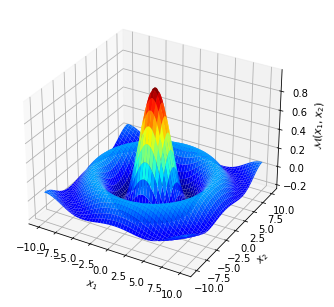

In [3]:
###############################################################################
# Definition of the original computational model

def M(x):
    """Fonction sinus Cardinal"""
    t = np.sqrt(np.sum(x ** 2., axis=1))
    z = np.sin(t) / t
    z[t == 0.] = 1.
    return z
'''
def M(x):
    """Fonction polynomiale."""
    t = np.sqrt(np.sum(x ** 2., axis=1))
    z = (t-2)**2
    return z
'''
# Definition of a grid to plot the model
res = 100
x1_plot, x2_plot = np.meshgrid(np.linspace(-10., 10., res),
                               np.linspace(-10., 10., res))
x_plot = np.vstack([x1_plot.ravel(), x2_plot.ravel()]).T
y_plot = M(x_plot).reshape(res, res)

# Plot
fig = pl.figure(1)
ax = Axes3D(fig)
ax.plot_surface(x1_plot, x2_plot, y_plot,
                rstride=2, cstride=2, cmap=pl.matplotlib.cm.jet,linewidth = 0.2)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$\mathcal{M}(x_1,\,x_2)$')
pl.show()

# 1. Polynomial Chaos 

## 1.1. Principle
The class of model is versatile: it is well suited to sensitivity studies (analytical calculation of sensitivity indices at $1^{st}$ order, $2^{ith}$ order and totals), but reliability studies can be considered and optimization.

Here, the vector of input parameters is assumed to be random.

- We consider the random variable $Y = \mathcal M(\mathbf X)$ as an element of a functional space, which we assume has finite variance.
- We build a base of this space, and we represent $Y$ by its coordinates (coefficients) in this base:

\begin{equation}
    Y = \sum_{j=0}^{+\infty} a_j \Psi_j (\mathbf X)
\end{equation}

where $a_j$ are the coefficients to be calculated, $\Psi$ is the polynomial basis. The coefficients $a_j$ completely characterize the random variable $Y$.

## 1.2. Construction de la base

### 1.2.1 Choix des polynômes

We assume that $\mathbf X \in \mathbb X^n$ has independent components. For each marginal distribution, we construct a family of polynomials orthogonal to the density of each variable $X_i$: $P_k^i$, $k \in \mathbb N$.

The choice of space is linked to the type of variable and therefore to the polynomial
corresponding one-dimensional. The theory gives the polynomials only
for some distributions:

- Normal -> Support in $\mathbb R$ ->  Hermite
- Uniform -> Support in $[-1 ; 1]$  ->  Legendre
- Gamma -> Support in $]0 ; +\infty]$ ->  Laguerre
- Chebyshev -> Support in $\mathbb R$ ->  Chebyshev
- Beta -> Support in $\mathbb R$ ->  Jacobi

In practice, we start by transforming the input random variables into normalized variables allowing to build the base (e.g. reduced centered Gaussians, uniform on $[-1;1]$, etc.).

\begin{equation}
    \boldsymbol \xi =T(\mathbf X)
\end{equation}

In [4]:
a = 10.

# Generation of an experimental design using the Sobol' sequence
distribution = ot.ComposedDistribution([ot.Uniform(-a, a)] * 2)

# Choix du type de polynômes de la base
dim = distribution.getDimension()
polynome = ot.LegendreFactory()
print ("Legendre Polynom")
print ("------------------")
for i in range(5):
    print ('Polynom order {} : '.format(i), polynome.build(i))
print ('')
    
# OpenTURNS possède une classe qui permet de construire les polynômes
# à partir de la distribution grâce à l'algorithmde de Gram-Schmidt :
# StandardDistributionPolynomialFactory
polyCol = [0.]*dim
for i in range(dim):
    polyCol[i] = ot.StandardDistributionPolynomialFactory(distribution.getMarginal(i))

print ("Polynomial for the first marginal of the study distribution")
print ("-----------------------------------------------------------------")
for i in range(5):
    print ('Polynom ordre {} : '.format(i), polyCol[0].build(i))

Legendre Polynom
------------------
Polynom order 0 :  1
Polynom order 1 :  1.73205 * X
Polynom order 2 :  -1.11803 + 3.3541 * X^2
Polynom order 3 :  -3.96863 * X + 6.61438 * X^3
Polynom order 4 :  1.125 - 11.25 * X^2 + 13.125 * X^4

Polynomial for the first marginal of the study distribution
-----------------------------------------------------------------
Polynom ordre 0 :  1
Polynom ordre 1 :  1.73205 * X
Polynom ordre 2 :  -1.11803 + 3.3541 * X^2
Polynom ordre 3 :  -3.96863 * X + 6.61438 * X^3
Polynom ordre 4 :  1.125 - 11.25 * X^2 + 13.125 * X^4


### 1.2.2 Tensorization of polynomials

The passage to a complete basis is done by tensorial product of the one-dimensional polynomials:

\begin{eqnarray}
    \boldsymbol \alpha = \{ \alpha_1, \ldots, \alpha_n \} \\
    \Psi_{\alpha} = \prod_{i=1}^n P_{\alpha_i}^i (X_i)
\end{eqnarray}

OpenTURNS also allows you to choose the way to order the polynomials: linear or hyperbolic, isotropic or anisotropic.

In [6]:
# Building the base
# By default the enumeration of polynomials is linear.
enumerateFunction = ot.EnumerateFunction(dim)
multivariateBasis = ot.OrthogonalProductPolynomialFactory(polyCol, enumerateFunction)

for i in range(10):
    print ('Polynom index {} : '.format(i), multivariateBasis.build(i))

Polynom index 0 :  1
Polynom index 1 :  1.73205 * x0
Polynom index 2 :  1.73205 * x1
Polynom index 3 :  -1.11803 + 3.3541 * x0^2
Polynom index 4 :  (1.73205 * x0) * (1.73205 * x1)
Polynom index 5 :  -1.11803 + 3.3541 * x1^2
Polynom index 6 :  -3.96863 * x0 + 6.61438 * x0^3
Polynom index 7 :  (-1.11803 + 3.3541 * x0^2) * (1.73205 * x1)
Polynom index 8 :  (1.73205 * x0) * (-1.11803 + 3.3541 * x1^2)
Polynom index 9 :  -3.96863 * x1 + 6.61438 * x1^3


### 1.2.3 Truncation

The theory shows that the decomposition on a chaos
polynomial is exact if we retain all the terms:

\begin{equation}
    Y =  \sum_{j=0}^{+\infty} a_j \Psi_j (\mathbf X) = \sum_{\boldsymbol \alpha \in \mathbb N^n} a_{\boldsymbol \alpha} \Psi_{\boldsymbol \alpha} (\mathbf X)
\end{equation}

In practice, we choose a one-degree truncation of the series $p$ and we generate the finite set $\mathcal A$ of associated multi-indices $\alpha$:

\begin{equation}
    \mathcal A = \left\{ \boldsymbol \alpha \in \mathbb N^n : ||\boldsymbol \alpha||_1 = \sum_{i=1}^n \alpha_i \leq p \right\}
\end{equation}

The truncation is written:
\begin{equation}
    Y \approx \tilde Y = \sum_{j=0}^{P-1} a_j \Psi_j (\mathbf X) = \sum_{\boldsymbol \alpha \in \mathbb N^n , 0 \leq |\boldsymbol \alpha| \leq p} a_\alpha \Psi_\alpha (\mathbf X)
\end{equation}

with $ P = \binom{n+p}{p} = \frac{(n+p)!}{n!p!}$.


In [7]:
# Choice of the maximum degree of chaos
p = 3
indexMax = enumerateFunction.getStrataCumulatedCardinal(p)
print ('p (degree max) = {}'.format(p))
print ('P (indice max) = {}' .format(indexMax))

p (degree max) = 3
P (indice max) = 10


## 1.3. Calculation of Coefficients

We limit ourselves here to non-intrusive methods, which make it possible to
solve the problem of calculating the coefficients.

Non-intrusive methods are based on a design of experiments
numerical, i.e. the evaluation of the model on a set of draws
input parameters.
They are classified into different approaches:

- by screening:
    - by simulation
    - by squaring
- by regression.


#### By regression:

We consider the expansion by polynomial chaos as the sum of the
truncated series and a residue:
\begin{equation}
    Y = \mathcal M(\mathbf X) = \sum_{j=0}^{P-1} a_j \Psi_j (\mathbf X) + \varepsilon_P
\end{equation}

The coefficients to be determined, grouped in the vector $\mathbf a$, are obtained by
minimizing the squared error (solving a least-squares problem):
\begin{equation}
    \mathbf a = \text{argmin } \mathbb E \left[ \left(\mathbf a^t \boldsymbol \Psi (\mathbf X) - \mathcal M(\mathbf X) \right)^2 \right]
\end{equation}


Plans based on Monte Carlo draws make it possible to
analysis. In order to better explore the parameter space, it is
advised to use an LHS plan.

In [8]:
# Choice of strategy for calculating the coefficients
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, indexMax)

# Choosing the Latin Hypercube (LHS) Generated Experiment Design
size = 100.
ot.RandomGenerator.SetSeed(0)
experiment = ot.LHSExperiment(distribution, int(size))


## 1.4. Class instantiation building chaos

#### Chaos with known plan of experiments

In [9]:
# Creating chaos with LHS sampling
inputSample = experiment.generate()
outputSample = ot.Sample(np.array([M(np.array(inputSample))]).T)

algochaos = ot.FunctionalChaosAlgorithm(inputSample,
                                   outputSample,
                                   distribution,
                                   adaptiveStrategy)

algochaos.run()
metaModelResult = algochaos.getResult()
metaModel = metaModelResult.getMetaModel()

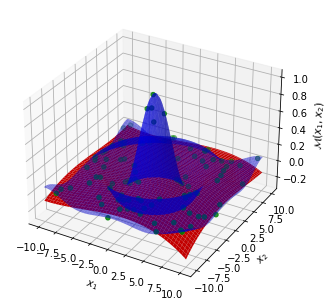

In [10]:
# Definition of a grid to plot the model
res = 100
x1_plot, x2_plot = np.meshgrid(np.linspace(-a, a, res),
                               np.linspace(-a, a, res))
x_plot = np.vstack([x1_plot.ravel(), x2_plot.ravel()]).T

# Compute the model and its predictor
y_plot = M(x_plot).reshape(res, res)
y_pred = np.array(metaModel(x_plot)).reshape(res, res)

# Plot
fig = pl.figure(2)
ax = Axes3D(fig)
ax.plot_surface(x1_plot, x2_plot, y_pred,
                rstride=2, cstride=2, color='r', linewidth = 0.1,alpha=1)
ax.plot_surface(x1_plot, x2_plot, y_plot,
                rstride=2, cstride=2, color='b', linewidth = 0.1,alpha=0.5)
ax.scatter3D(inputSample[:, 0], inputSample[:, 1], outputSample, 'g.', color='g')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$\mathcal{M}(x_1,\,x_2)$')
pl.show()

#### Summary :

- Polynomial chaos is an expansion on a particular polynomial basis.
- In theory, the expansion is exact (infinite expansion without truncations).
- In practice, we truncate the series: the chaos then becomes an approximation of the answer.
- The determination of the chaos passes by the calculation of the coefficients starting from a plan of experiments. There are two methods: projection or regression.

# 2.Kriging

The technique comes from mining engineering for prospecting (Krige, 1950) then it was formalized by the geostatistician Matheron (1962).

## 2.1. Principle

#### Objective
We want to predict the result $y$, deterministic, of an experiment $\mathcal M$ (physical or numerical) according to its parameters $\mathbf x$, also deterministic, from a sample of pairs $(\mathbf x, y)$.

#### Modeling by a Gaussian process
We assume that $y(\mathbf x)$ is a trajectory to be identified of a non-stationary Gaussian process $Y(\mathbf x)$ to be identified which is written in the form:

\begin{equation}
    Y(\mathbf x) = \mathbf f (\mathbf x)^t \boldsymbol \beta + Z(\mathbf x)
\end{equation}
where :

- $\mathbf f (\mathbf x)^t \boldsymbol \beta$ is the deterministic (trend) part that approximates the average response. The function $\mathbf f$ is determined by the experimenter's a priori knowledge of the phenomenon to be modelled. In general, the function is chosen constant, linear or quadratic.
- $Z(\mathbf x)$ is a stationary centered Gaussian process with isotropic or anisotropic covariance between two points with coordinates $x$ and $x'$ defined by:
    \begin{equation}
        C ( \mathbf x, \mathbf x') = \sigma^2 \prod_{i=1}^d R_i \left(\mathbf x - \mathbf x’\right)
    \end{equation}    
    where $d$ is the dimension of $\mathbf x$, $\sigma^2$ is the process variance, $R_i$ the autocorrelation function associated with the parameters $x_i, i=1,\ldots, d$.
    
#### The best unbiased linear predictor of $Y(\mathbf x)$
Kriging is a method of spatial interpolation which makes it possible to obtain the best
unbiased linear predictor (*Best Linear Unbiased Predictor, BLUP*). This technique
has several interesting features:

- it interpolates exactly the points of the design of experiments, i.e. the predictions necessarily pass through its learning points. The validation of the kriged surface must therefore be done outside the sites used! (Cross-validation methods: *leave-one-out*, *k-folds*).

- it provides a local confidence estimator on the predicted value via the kriging variance.

#### Parameter determination
- The deterministic part is chosen from a class of regression model: $\mu (\mathbf x) = \mathbf f (\mathbf x)^t \boldsymbol \beta$.
- The autocorrelation is also chosen in a known parameterized class $C ( \mathbf x, \mathbf x') = \sigma^2 R_{\boldsymbol \theta} \left(\mathbf x - \mathbf x'\right) $.

The determination of the optimal parameters $\hat{\boldsymbol \beta}, \hat{\sigma}^2, \hat{\boldsymbol \theta}$ is made from the vector of observations $\mathbf y \in \mathcal Y^m$ thanks to maximum likelihood. Writing the likelihood allows us to write $\hat{\boldsymbol \beta}$ and $\hat{\sigma}^2$ in terms of $\hat{\boldsymbol \theta}$. In the end, the determination of the parameters amounts to minimizing:
\begin{equation}
    \hat{\boldsymbol \theta} = \text{argmin}_{\boldsymbol \theta} \text{ } \hat{\sigma}^2 \text{det} \left( R_{\boldsymbol \theta} \right)^{1/m}
\end{equation}

It is an unconstrained nonlinear optimization problem that cannot be
not solve analytically. Therefore, optimization methods are used.
numerical dedicated to this problem.

## 2.2. Implementation in OpenTURNS

#### Choice of the deterministic part

In [11]:
# Constant, Linear ou Quadratic
basis = ot.LinearBasisFactory(dim).build()

#### Choice of autocorrelation function
In general, one chooses functions of the generalized exponential type, differentiable at the origin
in order to be able to model the continuous character of the model $\mathcal M$ if this is the case.

In [12]:
sqrtExp = ot.SquaredExponential([1], [0.2])

In [13]:
# Different examples of auto-correlation function
sqrtExp = ot.SquaredExponential([1], [0.2])
absExp = ot.AbsoluteExponential([1], [0.2])
matern32 = ot.MaternModel([1], [0.2], 1.5) # Derivable 1 time
matern52 = ot.MaternModel([1], [0.2], 2.5) # Derivable 2 times

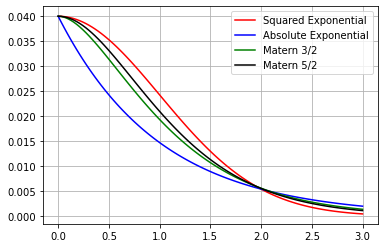

In [14]:
size = 100
support = np.linspace(0, 3, size)
cov_sqrtExp = np.ones(size)
cov_absExp = np.ones(size)
cov_matern32 = np.ones(size)
cov_matern52 = np.ones(size)

for i in range(size):
    cov_sqrtExp[i] = sqrtExp.computeAsScalar([support[i]])
    cov_absExp[i] = absExp.computeAsScalar([support[i]])
    cov_matern32[i] = matern32.computeAsScalar([support[i]])
    cov_matern52[i] = matern52.computeAsScalar([support[i]])
    
fig, ax = pl.subplots(figsize=(6, 4))
ax.plot(support, cov_sqrtExp, 'r')
ax.plot(support, cov_absExp, 'b')
ax.plot(support, cov_matern32, 'g')
ax.plot(support, cov_matern52, 'k')
ax.legend(['Squared Exponential', 'Absolute Exponential', 'Matern 3/2', 'Matern 5/2'])
ax.grid()
fig.show()

In [15]:
# SquaredExponential, AbsoluteExponential, GeneralizedExponential, MaternModel
# Choice of correlation for the kriging model
covarianceModel = ot.SquaredExponential([0.2], [0.1])

#### Instantiating the class building the kriging model

In [16]:
algokriging = ot.KrigingAlgorithm(inputSample, outputSample, covarianceModel, basis)

In [17]:
algokriging.run()
metaModelResult = algokriging.getResult()
metaModel = metaModelResult.getMetaModel()

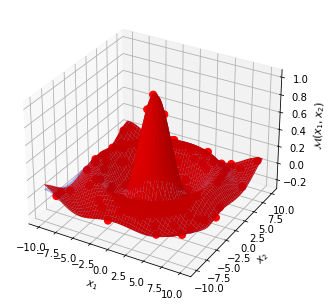

In [18]:
# Definition of a grid to plot the model


res = 100
x1_plot, x2_plot = np.meshgrid(np.linspace(-a, a, res),
                               np.linspace(-a, a, res))
x_plot = np.vstack([x1_plot.ravel(), x2_plot.ravel()]).T

# Compute the model and its predictor
y_plot = M(x_plot).reshape(res, res)
y_pred = np.array(metaModel(x_plot)).reshape(res, res)

# Plot
fig = pl.figure(2)
ax = Axes3D(fig)
ax.plot_surface(x1_plot, x2_plot, y_pred,
                rstride=2, cstride=2, color='r', linewidth = 0.1,alpha=1)
ax.plot_surface(x1_plot, x2_plot, y_plot,
                rstride=2, cstride=2, color='b', linewidth = 0.1,alpha=0.3)
ax.scatter3D(inputSample[:, 0], inputSample[:, 1], outputSample, 'g.', color='r', s=50,alpha=1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$\mathcal{M}(x_1,\,x_2)$')
pl.show()

# 3. Validation of metamodels
## 3.1. Graph and adjustment coefficient

The coefficient of determination $R^2$ quantifies the precision of the fit of the metamodel:
\begin{equation}
    R^2 = 1 - \frac{\displaystyle \sum_{k=1}^{m} \left( y_k  - \hat y_k \right)^2} {\displaystyle  \sum_{k=1}^{m} \left( y_k  - \overline y \right)^2}
\end{equation}
The numerator corresponds to the sum of the square of the residuals, the denominator corresponds to the sum of the square of the relative errors.µ

OpenTURNS implements a method to calculate the $R^2$: *MetaModelValidation*

#### Attention for kriging the $R^2$ is not relevant, because the metamodel is interpolating so it will be equal to 1.

--------------------------
R2 chaos   = 0.0579054
R2 kriging = 1.000000
--------------------------


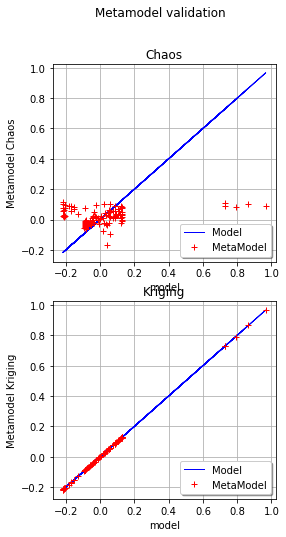

In [19]:
algoMetamodel = [algochaos, algokriging]
labels = ['Chaos', 'Kriging']

R2 = list()
fig = pl.figure(figsize=(4, 8))
ax = list()

for i, algo in enumerate(algoMetamodel):
    algo.run()
    metaModelResult = algo.getResult()
    metaModel = metaModelResult.getMetaModel()
    
    # Coefficient de détermination
    validation = ot.MetaModelValidation(inputSample, outputSample, metaModel)
    R2.append(validation.computePredictivityFactor())
    
    ax.append(fig.add_subplot(2, 1, i+1))
    View(validation.drawValidation(), axes=[ax[i]])
    ax[i].set_ylabel('Metamodel ' + labels[i])
    ax[i].set_title(labels[i])

print ('--------------------------')
print ('R2 chaos   = %0.7f' % R2[0])
print ('R2 kriging = %f' % R2[1])
print ('--------------------------')

#### Validation on a test sample
A test sample is drawn randomly (here according to a Sobol' sequence), it is evaluated by the real model and the metamodels. It is then possible to calculate the value of $R^2$ again and to represent the adjustment graph.

--------------------------
R2 chaos   = 0.0341994
R2 kriging = 0.9997164
--------------------------


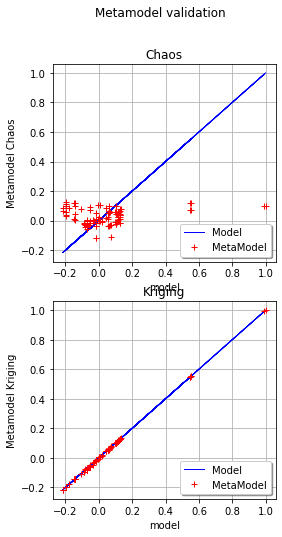

In [20]:
# Creation of the test sample
sizeTest = 100
Xtest = ot.LowDiscrepancyExperiment(ot.SobolSequence(), distribution, sizeTest).generate()

# Respons
Ytest = ot.Sample(np.array([M(np.array(Xtest))]).T)

# Evaluation de l'ajustement
# Coefficient de détermination
R2 = list()
fig = pl.figure(figsize=(4, 8))
ax = list()

for i, algo in enumerate(algoMetamodel):
    metaModelResult = algo.getResult()
    metaModel = metaModelResult.getMetaModel()
    
    validation = ot.MetaModelValidation(Xtest, Ytest, metaModel)
    R2.append(validation.computePredictivityFactor())
    
    ax.append(fig.add_subplot(2, 1, i+1))
    View(validation.drawValidation(), axes=[ax[i]])
    ax[i].set_ylabel('Metamodel ' + labels[i])
    ax[i].set_title(labels[i])

print ('--------------------------')
print ('R2 chaos   = %0.7f' % R2[0])
print ('R2 kriging = %0.7f' % R2[1])
print ('--------------------------')

## 3.2. Cross-validation

#### Goals
- Quantify the generalization capacity of a response surface.
- Choose the best response surface among several model classes or different sets of parameters (when building the metamodel in general).


#### Principle
- Given a design of experiments: $\mathcal D = (\mathbf x, y)$
- It is divided into two disjoint and complementary sub-databases: $\mathcal D_{fit} \cup \mathcal D_{valid} = \mathcal D$
- We fit a response surface on the base $\mathcal D_{fit}$ and we measure the error on the base $\mathcal D_{valid}$.
- Repeat the operation for all possible combinations.

####Two main techniques
- *Leave-one-out*: the validation base is only composed of one individual. This technique is used to calculate an adjustment coefficient, denoted $Q^2$, often called generalization coefficient:
    \begin{equation}
        Q^2 = 1 - \frac{\displaystyle \sum_{k=1}^{m} \left( y_k  - \hat y_{LOO, k} \right)^2} {\displaystyle  \sum_{k=1}^{m} \left( y_k  - \overline y \right)^2}
    \end{equation}
    where $\hat y_{LOO}$ is the vector of predictions by *leave-one-out*.
    The classical technique can be quite long to evaluate but there are methods to calculate it analytically.
    
    - For polynomial chaos:
    
        Note $err_{loo} = \frac{1}{m} \left( y_k - \hat y_{LOO, k} \right)^2$, the $Q^2$ can therefore be written in the form $ \displaystyle Q^2 = 1 - \frac{err_{loo}}{\text{Var}[\mathbf y]}$. The *Leave-One-Out* error can be approximated by the following formula:
        \begin{equation}
            err_{LOO} = \frac{1}{m} \sum_{k=1}^{m} \left( \frac{ y_k  - \hat y_k}{1 - h_k} \right)^2
        \end{equation}
        where $h_k$ is the $k$-th diagonal term of the matrix $\mathbf H = \mathbf A (\mathbf A^t \mathbf A)^{-1} \mathbf A^t$ with $A_{ij} = \Psi (x_j)$.
    - For Kriging, a technique was developed by O. Dubrule (1983). Cross validation of kriging in a unique neighborhood. Mathematical Geology, 15(6) 687--699. It allows to directly calculate $\hat{\mathbf y}_{LOO}$.
    
    
- *K-Folds*: this is another variant which consists in dividing the initial basis into *K* disjoint and complementary sub-bases of equivalent sizes:
    - We adjust on all the sub-bases except the $k$-th
    - We predict the $k$-th model thus adjusted on the $k$-th sub-base
    - The actual values ​​are compared to the values ​​predicted by an appropriate adjustment measure (e.g. a $R^2$).
    
    In general, we limit the number of *folds* between 5 and 10.

#### Using the scikit learn module

In [21]:
from sklearn.gaussian_process import gaussian_process as gp
import sklearn.cross_validation as cval
import warnings
warnings.filterwarnings('ignore')

C:\Users\benjamin.martin\AppData\Local\Continuum\anaconda3\envs\Formation6\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
C:\Users\benjamin.martin\AppData\Local\Continuum\anaconda3\envs\Formation6\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
# kriging scikit
x = np.array(inputSample)
y = np.array(outputSample)

# Instantiation of the Gaussian process
gp_scikit = gp.GaussianProcess(regr='linear',theta0=[1e-1], thetaL=[1e-4], thetaU=[1e1])
# Parameter optimization
gp_scikit.fit(x, y)
print ('theta_optimal = {:0.6f}'.format(gp_scikit.theta_[0]))

theta_optimal = 1.353018


In [23]:
# k-folds
kfold = 5
reskfold = cval.cross_val_score(gp_scikit, x, y, cv=cval.KFold(size, kfold))

# Leave-one-out
yloo = cval.cross_val_predict(gp_scikit, x, y, cv=cval.LeaveOneOut(size))
Q2 = 1 - np.mean((y - yloo)**2)/np.var(y)

print ('Kriging Scikit')
print ('Q2 = {}'.format(Q2))
print ('KFold = {}'.format(reskfold))

Kriging Scikit
Q2 = 0.9964234314431711
KFold = [0.99617102 0.99506011 0.99726156 0.99788664 0.99635645]
